---------
# 배추가격 예측 AI Project for 모인활

Notes by kjune18@naver.com, Handong Global Univ.

## 기대효과

- 선형 회귀까지만 공부한 사람도 실제로 기상청 등의 데이터에서 다양한 배추 가격 데이터를 수집하고 직접 활용하여 스스로 웹사이트까지 구축해볼 수 있다.
- 결과적으로 사용자의 입력값에 따라 적당한 배추 가격을 예측해주는 모델을 만들고, 모델을 통해 결과를 보여줄 수 있다.

## 포함되는 개념들

1. 파이썬 and Tensorflow에서 학습된 모델을 저장하고 필요에 따라서 불러오는 기능
2. Flask Web Server & Mdbootstrap Design Framework

## 1. 선형 회귀

선형 회귀는 통계학에서 종속 변수 $y$와 한 개 이상의 독립 변수 $x$와의 선형 상관 관계를 모델링하는 회귀분석 기법이다.
선형 회귀는 선형 예측 함수를 사용해 회귀식을 모델링하며, 알려지지 않은 파라미터는 데이터로부터 추정한다. 이렇게 만들어진 회귀식을 선형 모델이라고 한다.

선형 회귀는 여러 사용 사례가 있지만, 대개 아래와 같은 두 가지 분류 중 하나로 요약할 수 있다.
- 값을 예측하는 것이 목적일 경우, 선형 회귀를 사용해 데이터에 적합한 예측 모형을 개발한다. 개발한 선형 회귀식을 사용해 $y$가 없는 $x$값에 대해 $y$를 예측하기 위해 사용할 수 있다.


- 종속 변수 $y$와 이것과 연관된 독립 변수 $X_1$,  ...   ,$X_p$
가 존재하는 경우에, 선형 회귀 분석을 사용해 $X_j$와 $y$의 관계를 정량화할 수 있다.


<img src = "https://upload.wikimedia.org/wikipedia/commons/b/be/Normdist_regression.png" width=300>
<center>그림 1: 독립변수 1개와 종속변수 1개를 가진 선형 회귀의 예

## 2. 데이터 수집

우리나라 정부에서는 다양한 데이터를 무료로 제공해주고 있다. 그러나, 데이터를 제공하는 정책이 서로 다를 수 있기 때문에 데이터를 수집하는 방법에 있어서는 조금씩 다르게 활용할 필요가 있다.

### 기상청 자료 이용하기

1. 기상자료개방포털(기후통계분석)로 이동한다.
2. 먼저 기온분석으로 이동하여, 원하는 기간과 지역/지점을 선택하고 csv다운로드 버튼을 눌러 데이터를 얻도록 한다.
3. 다음으로 강수량분석으로 이동하여, 앞에서 받은 데이터와 동일한 기간, 동일한 지역/지점을 선택하고 csv다운로드 버튼을 통해 데이터를 얻도록 한다.

### 농산물유통 자료 이용하기

1. 농산물유통정보사이트로 이동한다.
2. 가격정보에서 채소류->배추를 선택하고, 품종과 등급은 전체로 하여 조회한다.
3. 데이터 저장버튼을 통해 데이터를 얻도록 한다.

## 3. 데이터 정제

처음 수집한 data는 인공지능이 인식하기 쉬운 형태는 아니다.
따라서 엑셀 내부의 data를 정제함으로써 인공지능이 인식하기 쉬운 형태로 만들어 줘야 한다.
특히 배추의 가격은 주말 등에는 측정되지 않는 점이 있고, 몇몇 일자에는 가격이 급상승하는 data가 있기 때문에 data의 정제가 반드시 필요하다.

여기에서 사용할 변인은 평균온도, 최저온도, 최고온도, 강수량 총 4가지 변인을 사용하여 가격을 예측하도록 할 것이다.
<img src = "https://t1.daumcdn.net/cfile/tistory/99D710465B7D9A8E18" width= 300>

정제된 data 링크 https://github.com/returnb2b/AI-for-All/blob/main/Projects/Vegita_Project/price%20data.csv

### 3-1. 데이터 시각화

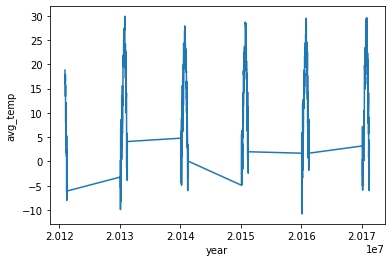

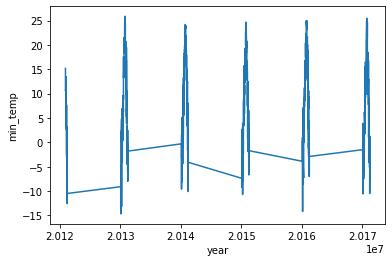

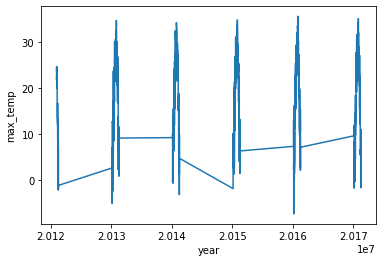

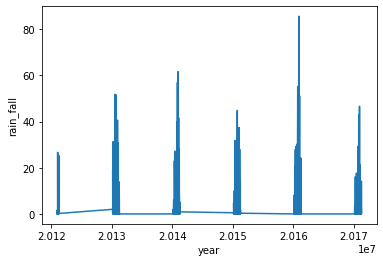

In [22]:
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
import numpy as np

visual_data = read_csv('price data.csv')  # csv파일 읽어오기

xy = np.array(visual_data)    # 행렬 형태로 저장하기

# 4개의 변인
datas = xy[:,1:-1]   # slicing x

plt.plot(xy[1000:,[0]], datas[1000:,[0]])
plt.xlabel('year')
plt.ylabel('avg_temp')
plt.show()

plt.plot(xy[1000:,[0]], datas[1000:,[1]])
plt.xlabel('year')
plt.ylabel('min_temp')
plt.show()

plt.plot(xy[1000:,[0]], datas[1000:,[2]])
plt.xlabel('year')
plt.ylabel('max_temp')
plt.show()

plt.plot(xy[1000:,[0]], datas[1000:,[3]])
plt.xlabel('year')
plt.ylabel('rain_fall')
plt.show()

## 4. 모델 만들기

다변인 선형 회귀는 모델에 영향을 미치는 변인이 여러 개 일때 사용하는 모델이다. 현재 우리의 데이터에서는 변인이 '평균온도', '최저온도', 최고온도', '강수량'이므로 이 모든 요인이 '가격'에 영향을 미친다고 감안해야 한다. 따라서 가중치(Weight)을 고려했을 때 다음과 같은 수식을 세울 수 있다.

$H(x_1, x_2, x_3, x_4) = x_1w_1 + x_2w_2 + x_3w_3 + x_4w_4$

파이썬에서 Tensorflow 라이브러리를 활용해 다변인 선형 회귀 모델을 구현한다.

In [23]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [24]:
# 엑셀에서 data를 읽어온다.
# pandas library: excel data를 읽어올 수 있다.
from pandas.io.parsers import read_csv

data = read_csv('price data.csv',sep=',')  # csv파일 읽어오기
xy = np.array(data, dtype=np.float32)    # 행렬 형태로 저장하기

In [25]:
# 4개의 변인을 입력을 받는다.
# 각각 avgTemp, minTemp, maxTemp, rainFall
x_data = xy[:, 1:-1]   # slicing x
print(x_data)

# 가격 값을 입력 받는다.
y_data = xy[:, -1:]   # slicing y
print(y_data)

[[ -4.9 -11.    0.9   0. ]
 [ -3.1  -5.5   5.5   0.8]
 [ -2.9  -6.9   1.4   0. ]
 ...
 [  2.9  -2.1   8.    0. ]
 [  2.9  -1.6   7.1   0.6]
 [  2.1  -2.    5.8   0.4]]
[[2123.]
 [2123.]
 [2123.]
 ...
 [2901.]
 [2901.]
 [2901.]]


모델은 keras모듈에서 제공해주는 Sequential모델을 사용하도록 한다.

- Sequential모델은 각 레이어(layer)를 선형으로 연결하여 구성하는 모델이다.
- 레이어 인스턴스를 생성자에게 넘겨줌으로써 Sequential모델을 구성할 수 있다.

다음과 같이 모델 구조를 생성할 수 있다.

In [26]:
model = tf.keras.models.Sequential()

만들어진 모델은 입력 형태에 대한 정보를 필요로 한다. 때문에 Sequential 모델의 첫 번째 레이어는 입력 형태에 대한 정보를 받는다. 두 번째 이후 레이어들은 자동으로 형태를 추정할 수 있기 때문에 형태 정보를 갖고 있을 필요는 없다. 형태 정보를 전달하기 위한 방법은 다음과 같다.

In [27]:
model.add(tf.keras.layers.Dense(1,input_dim=4))

- 여기서 사용한 Dense 레이어는 입력과 출력을 모두 연결해 주는 2D 레이어이다.
- 첫번째 인자: 출력 뉴런의 수를 설정한다.
- 두번째 인자(input_dim): 입력 뉴런의 수를 설정한다.
Dense와 같은 2D 레이어의 경우에는 입력 형태를 `input_dim` 인자를 통해 지정할 수 있다.

그 외에도 다양한 인자를 추가할 수도 있다. (init(가중치 초기화), activation(활성화 함수) 등)

W(가중치) 값과 b(바이어스) 의 값을 지정해야 하는데 이는 학습을 위해 임의의 값 (아직 잘 모른다고 가정)을 던져준다.

텐서플로우에서는 W와 b에 해당하는 변수를 Variable 을 사용하여 나타낸다. 그리고 텐서 플로우가 알아서 이 값을 자동으로 조절해 줄 것이며 나중에 비용함수가 최소(minimize)가 되는 가중치와 바이어스 값으로 조정하게 된다.

In [28]:
# 최적화 함수를 설정한다. 여기선 GradientDescent(경사하강) 함수 사용
# 학습률 0.000005로 설정한 이유 - 되도록 짧은 시간에 정확한 결과 나오게 하기 위함
# 경사하강의 간격

# optimizer
# 확률적 경사하강법
sgd = tf.keras.optimizers.SGD(lr=0.000005)

C:\Users\wev12\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [29]:
# cost / loss function
model.compile(loss='mse', optimizer=sgd)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [32]:
# 학습시키기
# batch_size는 몇장을 보고 맞춰보는지 확인하는 것이다.
history = model.fit(x_data,y_data,epochs=200,batch_size=128)
print("학습이 종료되었습니다.")

Epoch 1/200
23/23 [==============================] - 1s 2ms/step - loss: 11325077.0000
Epoch 2/200
23/23 [==============================] - 0s 1ms/step - loss: 9117548.0000
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 7630470.0000
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 6623035.0000
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 5940478.5000
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 5473904.5000
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 5152734.5000
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 4929369.0000
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 4771648.5000
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 4658190.0000
Epoch 11/200
23/23 [==============================] - 0s 1ms/step - loss: 4574807.5000
Epoch 12/200
23/23 [==============================]

23/23 [==============================] - 0s 1ms/step - loss: 3149947.0000
Epoch 96/200
23/23 [==============================] - 0s 1ms/step - loss: 3140736.5000
Epoch 97/200
23/23 [==============================] - 0s 1ms/step - loss: 3131608.5000
Epoch 98/200
23/23 [==============================] - 0s 1ms/step - loss: 3122363.5000
Epoch 99/200
23/23 [==============================] - 0s 1ms/step - loss: 3113200.5000
Epoch 100/200
23/23 [==============================] - 0s 1ms/step - loss: 3104251.0000
Epoch 101/200
23/23 [==============================] - 0s 1ms/step - loss: 3095346.7500
Epoch 102/200
23/23 [==============================] - 0s 1ms/step - loss: 3086670.7500
Epoch 103/200
23/23 [==============================] - 0s 1ms/step - loss: 3078003.0000
Epoch 104/200
23/23 [==============================] - 0s 1ms/step - loss: 3069394.5000
Epoch 105/200
23/23 [==============================] - 0s 1ms/step - loss: 3060893.7500
Epoch 106/200
23/23 [=============================

23/23 [==============================] - 0s 1ms/step - loss: 2598922.5000
Epoch 189/200
23/23 [==============================] - 0s 1ms/step - loss: 2595525.0000
Epoch 190/200
23/23 [==============================] - 0s 1ms/step - loss: 2592087.2500
Epoch 191/200
23/23 [==============================] - 0s 1ms/step - loss: 2588731.5000
Epoch 192/200
23/23 [==============================] - 0s 1ms/step - loss: 2585459.5000
Epoch 193/200
23/23 [==============================] - 0s 1ms/step - loss: 2582149.2500
Epoch 194/200
23/23 [==============================] - 0s 1ms/step - loss: 2578860.0000
Epoch 195/200
23/23 [==============================] - 0s 1ms/step - loss: 2575644.7500
Epoch 196/200
23/23 [==============================] - 0s 1ms/step - loss: 2572437.7500
Epoch 197/200
23/23 [==============================] - 0s 1ms/step - loss: 2569383.2500
Epoch 198/200
23/23 [==============================] - 0s 1ms/step - loss: 2566193.5000
Epoch 199/200
23/23 [=========================

- 학습모델을 저장하는 이유

만약 학습 모델을 저장하지 않고 사용자로부터 배추 가격 예측 요청(Request)이 발생할 때마다 매 번 학습을 해서 결과를 돌려준다면 시간이 오래 걸리고 많은 리소스가 소모 될 것이다.

  따라서 오프라인(Offline)에서 주기적으로 데이터를 이용해 학습을 진행한 뒤에, 그 결과를 저장해서 서버에서는 실시간 요청에 따라 이미 저장된 학습 모델로 배추 가격을 예측하는 것이 효율적이다.

In [33]:
model.evaluate(x_data, y_data)

92/92 [==============================] - 0s 890us/step - loss: 2558367.7500


2558367.75

In [35]:
print(history.history.keys())

dict_keys(['loss'])


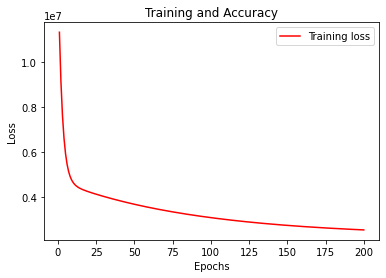

In [37]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(1, len(loss) + 1)            # for x, use len(loss)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
# 학습된 모델을 저장한다.
model.save('./my_saved/saved.ckpt')
print("학습된 모델을 저장했습니다.")

INFO:tensorflow:Assets written to: ./my_saved/saved.ckpt\assets
학습된 모델을 저장했습니다.


## 참고자료

1. 선형회귀 위키백과(https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%ED%9A%8C%EA%B7%80)
1. 안경잡이개발자  
https://ndb796.tistory.com/124
1. 텐서플로우 기본 문법  
https://gdyoon.tistory.com/8  
https://gdyoon.tistory.com/5  
https://zetawiki.com/wiki/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0_random_normal()